In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size':14})

In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

# Загружаем данные

In [3]:
df_train = pd.read_csv('train.csv')

In [4]:
df_test = pd.read_csv('test.csv')

In [5]:
data_train = df_train.copy()

In [6]:
data_test = df_test.copy()

# Предварительная обработка данных

### Rooms 

In [7]:
data_train.loc[(data_train['Rooms']>6)&(data_train['Square']>58)&(data_train['Square']<61), 'Rooms'] = data_train.loc[(data_train['Square']>58)&(data_train['Square']<61), 'Rooms'].median()

In [8]:
data_train.loc[(data_train['Rooms']>6)&(data_train['Square']>41)&(data_train['Square']<43), 'Rooms'] = data_train.loc[(data_train['Square']>41)&(data_train['Square']<43), 'Rooms'].median()

In [9]:
data_test.loc[(data_test['Rooms']>6)&(data_test['Square']>52)&(data_test['Square']<53), 'Rooms'] = data_test.loc[(data_test['Square']>52)&(data_test['Square']<53), 'Rooms'].median()

### HouseYear

In [10]:
data_train.loc[data_train['Id']==10814, 'HouseYear']=2011

In [11]:
data_train.loc[data_train
               
               ['Id']==11607, 'HouseYear']=1968

### HouseFloor

In [12]:
data_train.loc[data_train['HouseFloor']>50, 'HouseFloor'] = data_train.loc[data_train['HouseFloor']>25, 'HouseFloor']//10

In [13]:
data_train.loc[data_train['HouseFloor']==0, 'Id'].count()

269

In [14]:
median_floor = data_train.loc[data_train['HouseYear']!=0].groupby(['HouseYear', 'Floor']).agg({'HouseFloor':'median'})
median_floor =  median_floor.rename(columns={'HouseFloor':'HouseFloor_median'})
median_floor.head()

HouseFloor_median
HouseYear Floor                   
1910      8                    9.0
1912      3                    9.0
          6                    7.0
1914      8                    6.0
1916      4                    6.0

In [15]:
data_train = pd.merge(data_train, median_floor, on=['HouseYear', 'Floor'], how='left')

In [16]:
data_train.loc[data_train['HouseFloor']==0, 'HouseFloor']=data_train.loc[data_train['HouseFloor']==0, 'HouseFloor_median']

In [17]:
data_train.loc[data_train['Floor']>data_train['HouseFloor'], 'Id'].count()

1566

In [18]:
data_train.loc[data_train['Floor']>data_train['HouseFloor'], ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median
14,27,1.0,53.769097,52.408027,1.0,5,4.0,12.0
16,27,2.0,49.360648,31.993964,5.0,6,5.0,12.0
21,27,2.0,64.711835,NaN,1.0,15,1.0,17.0
35,200,3.0,85.280389,58.447967,9.0,6,5.0,5.0
51,94,1.0,35.280894,23.354176,6.0,11,9.0,9.0


In [19]:
data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']<data_train['HouseFloor_median']), 'Id'].count()

803

In [20]:
data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']<data_train['HouseFloor_median']), ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median
14,27,1.0,53.769097,52.408027,1.0,5,4.0,12.0
16,27,2.0,49.360648,31.993964,5.0,6,5.0,12.0
21,27,2.0,64.711835,NaN,1.0,15,1.0,17.0
76,34,1.0,47.909327,42.782385,1.0,2,1.0,4.0
86,148,3.0,127.481583,NaN,1.0,16,1.0,19.5


In [21]:
data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']<data_train['HouseFloor_median']), 'HouseFloor'] = data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']<data_train['HouseFloor_median']), 'HouseFloor_median']

In [22]:
data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']>data_train['HouseFloor_median']), 'Id'].count()

659

In [23]:
data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']>data_train['HouseFloor_median']), ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median
35,200,3.0,85.280389,58.447967,9.0,6,5.0,5.0
51,94,1.0,35.280894,23.354176,6.0,11,9.0,9.0
67,57,2.0,45.964890,29.141212,5.0,7,5.0,5.0
68,77,1.0,42.678844,23.918634,8.0,14,12.0,12.0
72,74,1.0,52.457589,52.423345,0.0,18,17.0,17.0


In [24]:
data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']>data_train['HouseFloor_median']), 'Floor']=data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']>data_train['HouseFloor_median']), 'HouseFloor_median']

In [25]:
data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']==data_train['HouseFloor_median']), 'Id'].count()

186

In [26]:
data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']==data_train['HouseFloor_median']), ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median
315,27,1.0,37.370830,39.184607,1.0,12.0,1.0,12.0
380,100,2.0,57.215321,35.283886,7.0,10.0,9.0,10.0
415,48,1.0,41.178714,38.003970,8.0,20.5,1.0,20.5
492,34,1.0,47.648489,NaN,1.0,17.0,15.0,17.0
582,63,1.0,58.959447,56.542921,1.0,20.0,18.0,20.0


In [27]:
data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']==data_train['HouseFloor_median']), 'HouseFloor'] = data_train.loc[(data_train['Floor']>data_train['HouseFloor'])&(data_train['Floor']==data_train['HouseFloor_median']), 'HouseFloor_median']

In [28]:
data_train.loc[data_train['Floor']>data_train['HouseFloor'], ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median


In [29]:
data_train.loc[data_train['HouseFloor'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_median


In [30]:
data_train.loc[data_train['Floor'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_median


In [31]:
data_test.loc[data_test['HouseFloor']>50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
651,15864,27,3.0,47.722835,47.098813,9.0,18,99.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [32]:
data_test.loc[data_test['HouseFloor']>50, 'HouseFloor'] = data_test.loc[data_test['HouseFloor']>25, 'HouseFloor']//10

In [33]:
data_test.loc[data_test['HouseFloor']==0, 'Id'].count()

131

In [34]:
median_floor = data_test.loc[data_test['HouseYear']!=0].groupby(['HouseYear', 'Floor']).agg({'HouseFloor':'median'})
median_floor =  median_floor.rename(columns={'HouseFloor':'HouseFloor_median'})
median_floor.head()

,,HouseFloor_median
HouseYear,Floor,
1908,7,8.0
1909,2,5.0
1910,5,5.0
1911,3,7.0
1912,7,6.0


In [35]:
data_test = pd.merge(data_test, median_floor, on=['HouseYear', 'Floor'], how='left')

In [36]:
data_test.loc[data_test['HouseFloor']==0, 'HouseFloor']=data_test.loc[data_test['HouseFloor']==0, 'HouseFloor_median']

In [37]:
data_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,HouseFloor_median
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.907000,56.449500,36.158810,5.976800,8.632000,12.9666,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800,13.003400
std,4832.674037,44.179466,0.810976,19.092787,17.825287,9.950018,5.483228,6.3977,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365,5.328956
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,1.0000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.0000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000,9.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,14.0000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,14.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.0000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000,17.000000
max,16795.000000,212.000000,6.000000,223.453689,303.071094,620.000000,78.000000,48.0000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,48.000000


In [38]:
data_test.loc[data_test['Floor']>data_test['HouseFloor'], 'Id'].count()

761

In [39]:
data_test.loc[data_test['Floor']>data_test['HouseFloor'], ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median
1,74,2.0,69.263183,NaN,1.0,6,1.0,17.0
10,61,3.0,64.543658,42.651541,7.0,10,9.0,12.0
14,27,1.0,37.555197,NaN,1.0,5,1.0,9.0
27,58,1.0,48.610661,48.752502,1.0,4,3.0,12.0
36,205,1.0,37.480811,16.851795,8.0,6,5.0,5.0


In [40]:
data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']<data_test['HouseFloor_median']), 'Id'].count()

385

In [41]:
data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']<data_test['HouseFloor_median']), ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median
1,74,2.0,69.263183,NaN,1.0,6,1.0,17.0
10,61,3.0,64.543658,42.651541,7.0,10,9.0,12.0
14,27,1.0,37.555197,NaN,1.0,5,1.0,9.0
27,58,1.0,48.610661,48.752502,1.0,4,3.0,12.0
55,27,1.0,48.587913,42.596190,12.0,3,2.0,5.5


In [42]:
data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']<data_test['HouseFloor_median']), 'HouseFloor'] = data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']<data_test['HouseFloor_median']), 'HouseFloor_median']

In [43]:
data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']>data_test['HouseFloor_median']), 'Id'].count()

331

In [44]:
data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']>data_test['HouseFloor_median']), ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median
36,205,1.0,37.480811,16.851795,8.0,6,5.0,5.0
41,21,2.0,49.011976,27.980195,5.0,6,5.0,5.0
58,21,1.0,21.452899,15.798509,3.0,11,9.0,9.0
65,48,1.0,40.767892,37.236548,1.0,20,19.0,18.5
75,75,1.0,34.591390,18.765600,9.0,13,12.0,12.0


In [45]:
data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']>data_test['HouseFloor_median']), 'Floor']=data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']>data_test['HouseFloor_median']), 'HouseFloor_median']

In [46]:
data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']==data_test['HouseFloor_median']), 'Id'].count()

90

In [47]:
data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']==data_test['HouseFloor_median']), ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median
76,99,2.0,52.156529,30.095966,8.0,18.0,17.0,18.0
77,45,2.0,59.927502,3.798341,1.0,11.5,1.0,11.5
174,23,1.0,31.167933,30.527056,0.0,11.0,9.0,11.0
176,45,1.0,39.353898,NaN,1.0,17.0,1.0,17.0
217,52,2.0,66.509248,NaN,1.0,19.0,17.0,19.0


In [48]:
data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']==data_test['HouseFloor_median']), 'HouseFloor'] = data_test.loc[(data_test['Floor']>data_test['HouseFloor'])&(data_test['Floor']==data_test['HouseFloor_median']), 'HouseFloor_median']

In [49]:
data_test.loc[data_test['Floor']>data_test['HouseFloor'], ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseFloor_median']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseFloor_median


In [50]:
data_test.loc[data_test['HouseFloor'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseFloor_median


In [51]:
data_test.loc[data_train['Floor'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseFloor_median


In [52]:
data_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,HouseFloor_median
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.907000,56.449500,36.158810,5.976800,8.520100,13.7805,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800,13.003400
std,4832.674037,44.179466,0.810976,19.092787,17.825287,9.950018,5.320894,5.8483,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365,5.328956
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,1.0000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.0000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000,9.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,14.0000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,14.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.0000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000,17.000000
max,16795.000000,212.000000,6.000000,223.453689,303.071094,620.000000,46.000000,48.0000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,48.000000


### Square 

In [53]:
data_train.loc[data_train['Square']>300, 'Square'] = data_train.loc[data_train['Square']>300, 'Square']/10

In [54]:
median_square = data_train.loc[data_train['Square']>15].groupby(['DistrictId', 'HouseYear', 'Rooms']).agg({'Square':'median'})
median_square = median_square.rename(columns={'Square':'Square_median'})
median_square.head()

Square_median
DistrictId HouseYear Rooms               
0          1959      2.0        45.662268
           1960      3.0        76.585035
           1961      1.0        25.233207
           1962      1.0        27.409047
           1963      1.0        34.487813

In [55]:
data_train = pd.merge(data_train, median_square, on=['DistrictId', 'HouseYear', 'Rooms'], how='left')

In [56]:
data_train.loc[data_train['Square']<15, 'Square'] = data_train.loc[data_train['Square']<15, 'Square_median']

In [57]:
median_square = data_test.loc[data_test['Square']>15].groupby(['DistrictId', 'HouseYear', 'Rooms']).agg({'Square':'median'})
median_square = median_square.rename(columns={'Square':'Square_median'})
median_square.head()

Square_median
DistrictId HouseYear Rooms               
0          1938      2.0        45.823556
           1961      1.0        34.142269
           1962      2.0        43.489378
           1963      3.0        58.022047
           1965      2.0        48.471822

In [58]:
data_test = pd.merge(data_test, median_square, on=['DistrictId', 'HouseYear', 'Rooms'], how='left')

In [59]:
median_square_2 = data_test.loc[data_test['Square']>15].groupby(['HouseYear', 'Rooms']).agg({'Square':'median'})
median_square_2 = median_square_2.rename(columns={'Square':'Square_median_2'})
median_square_2.head()

,,Square_median_2
HouseYear,Rooms,
1908,5.0,157.976101
1910,3.0,61.400464
1911,1.0,52.708494
1912,4.0,76.428426
1914,2.0,78.165510


In [60]:
data_test = pd.merge(data_test, median_square_2, on=['HouseYear', 'Rooms'], how='left')

In [61]:
data_test.loc[data_test['Square'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseFloor_median,Square_median,Square_median_2


In [62]:
data_test.loc[data_test['Square'].isnull(), 'Square'] = data_test.loc[data_test['Square'].isnull(), 'Square_median_2']

In [63]:
data_test.loc[data_test['Square'].isnull(), 'Square'] = data_test.loc[data_test['Square'].isnull(), 'LifeSquare']

### LifeSquare

In [64]:
data_train.loc[data_train['LifeSquare']>1000, 'LifeSquare'] = data_train.loc[data_train['LifeSquare']>1000, 'LifeSquare']/100

In [65]:
data_train.loc[data_train['LifeSquare']>250, 'LifeSquare'] = data_train.loc[data_train['LifeSquare']>250, 'LifeSquare']/10

In [66]:
median_lifesquare = data_train.loc[data_train['LifeSquare']>11].groupby(['DistrictId', 'HouseYear', 'Rooms']).agg({'LifeSquare':'median'})
median_lifesquare = median_lifesquare.rename(columns={'LifeSquare':'LifeSquare_median'})
median_lifesquare.head()

LifeSquare_median
DistrictId HouseYear Rooms                   
0          1959      2.0            30.086910
           1960      3.0            52.310864
           1961      1.0            17.165192
           1962      1.0            17.165120
           1963      1.0            22.458690

In [67]:
data_train = pd.merge(data_train, median_lifesquare, on=['DistrictId', 'HouseYear', 'Rooms'], how='left')

In [68]:
data_train.loc[(data_train['LifeSquare']<15)&(data_train['Rooms']>1), 'LifeSquare'] = data_train.loc[(data_train['LifeSquare']<15)&(data_train['Rooms']>1), 'LifeSquare_median']

In [69]:
data_train.loc[(data_train['LifeSquare']<11)&(data_train['Rooms']<2), 'LifeSquare'] = data_train.loc[(data_train['LifeSquare']<11)&(data_train['Rooms']<2), 'LifeSquare_median']

In [70]:
data_train.loc[data_train['LifeSquare'].isna(), 'LifeSquare'] = data_train.loc[data_train['LifeSquare'].isna(), 'LifeSquare_median']

In [71]:
median_lifesquare_2 = data_train.loc[data_train['LifeSquare']>11].groupby(['HouseYear', 'Rooms']).agg({'LifeSquare':'median'})
median_lifesquare_2 = median_lifesquare_2.rename(columns={'LifeSquare':'LifeSquare_median_2'})
median_lifesquare_2.head()

LifeSquare_median_2
HouseYear Rooms                     
1910      1.0              15.920343
1912      1.0              29.389815
          4.0              98.187482
1914      2.0              28.384213
1916      3.0              48.322107

In [72]:
data_train = pd.merge(data_train, median_lifesquare_2, on=['HouseYear', 'Rooms'], how='left')

In [73]:
data_train.loc[data_train['LifeSquare'].isna(), 'LifeSquare'] = data_train.loc[data_train['LifeSquare'].isna(), 'LifeSquare_median_2']

In [74]:
data_train.drop([3911],axis=0,inplace=True)

In [75]:
data_train.loc[data_train['Square']>data_train['LifeSquare'], 'LifeSquare_Square'] = data_train.loc[data_train['Square']>data_train['LifeSquare'], 'LifeSquare']/data_train.loc[data_train['Square']>data_train['LifeSquare'], 'Square']

In [76]:
LifeSquare_Square_median = data_train.loc[data_train['Square']>data_train['LifeSquare']].groupby(['DistrictId', 'HouseYear', 'Rooms']).agg({'LifeSquare_Square':'median'})
LifeSquare_Square_median = LifeSquare_Square_median.rename(columns={'LifeSquare_Square':'LifeSquare_Square_median'})
LifeSquare_Square_median.head()

LifeSquare_Square_median
DistrictId HouseYear Rooms                          
0          1959      2.0                    0.658901
           1960      3.0                    0.683043
           1961      1.0                    0.700949
           1962      1.0                    0.659205
           1963      1.0                    0.651207

In [77]:
data_train = pd.merge(data_train, LifeSquare_Square_median, on=['DistrictId', 'HouseYear', 'Rooms'], how='left')

In [78]:
LifeSquare_Square_median_2 = data_train.loc[data_train['Square']>data_train['LifeSquare']].groupby(['HouseYear', 'Rooms']).agg({'LifeSquare_Square':'median'})
LifeSquare_Square_median_2 = LifeSquare_Square_median_2.rename(columns={'LifeSquare_Square':'LifeSquare_Square_median_2'})
LifeSquare_Square_median_2.head()

LifeSquare_Square_median_2
HouseYear Rooms                            
1910      1.0                      0.313338
1912      1.0                      0.464345
          4.0                      0.649600
1914      2.0                      0.505306
1916      3.0                      0.469309

In [79]:
data_train = pd.merge(data_train, LifeSquare_Square_median_2, on=['HouseYear', 'Rooms'], how='left')

In [80]:
data_train.loc[(data_train['Square']<data_train['LifeSquare'])&(data_train['LifeSquare_Square_median'].notnull()), 'LifeSquare'] = data_train.loc[(data_train['Square']<data_train['LifeSquare'])&(data_train['LifeSquare_Square_median'].notnull()), 'Square']*data_train.loc[(data_train['Square']<data_train['LifeSquare'])&(data_train['LifeSquare_Square_median'].notnull()), 'LifeSquare_Square_median']

In [81]:
data_train.loc[(data_train['Square']<data_train['LifeSquare'])&(data_train['LifeSquare_Square_median'].isnull()), 'LifeSquare'] = data_train.loc[(data_train['Square']<data_train['LifeSquare'])&(data_train['LifeSquare_Square_median'].isnull()), 'Square']*data_train.loc[(data_train['Square']<data_train['LifeSquare'])&(data_train['LifeSquare_Square_median'].isnull()), 'LifeSquare_Square_median_2']

In [82]:
data_test.loc[data_test['LifeSquare']>250, 'LifeSquare'] = data_test.loc[data_test['LifeSquare']>250, 'LifeSquare']/10

In [83]:
median_lifesquare = data_test.loc[data_test['LifeSquare']>11].groupby(['DistrictId', 'HouseYear', 'Rooms']).agg({'LifeSquare':'median'})
median_lifesquare = median_lifesquare.rename(columns={'LifeSquare':'LifeSquare_median'})
median_lifesquare.head()

LifeSquare_median
DistrictId HouseYear Rooms                   
0          1938      2.0            27.462574
           1961      1.0            18.635812
           1962      2.0            29.407841
           1963      3.0            38.197976
           1965      2.0            33.794655

In [84]:
data_test = pd.merge(data_test, median_lifesquare, on=['DistrictId', 'HouseYear', 'Rooms'], how='left')

In [85]:
data_test.loc[(data_test['LifeSquare']<15)&(data_test['Rooms']>1), 'LifeSquare'] = data_test.loc[(data_test['LifeSquare']<15)&(data_test['Rooms']>1), 'LifeSquare_median']

In [86]:
data_test.loc[(data_test['LifeSquare']<11)&(data_test['Rooms']<2), 'LifeSquare'] = data_test.loc[(data_test['LifeSquare']<11)&(data_test['Rooms']<2), 'LifeSquare_median']

In [87]:
data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare'] = data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare_median']

In [88]:
median_lifesquare_2 = data_test.loc[data_test['LifeSquare']>11].groupby(['HouseYear', 'Rooms']).agg({'LifeSquare':'median'})
median_lifesquare_2 = median_lifesquare_2.rename(columns={'LifeSquare':'LifeSquare_median_2'})
median_lifesquare.head()

LifeSquare_median
DistrictId HouseYear Rooms                   
0          1938      2.0            27.462574
           1961      1.0            18.635812
           1962      2.0            29.407841
           1963      3.0            38.197976
           1965      2.0            33.794655

In [89]:
data_test = pd.merge(data_test, median_lifesquare_2, on=['HouseYear', 'Rooms'], how='left')

In [90]:
data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare'] = data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare_median_2']

In [91]:
median_lifesquare_3 = data_test.loc[data_test['LifeSquare']>11].groupby(['Rooms']).agg({'LifeSquare':'median'})
median_lifesquare_3 = median_lifesquare_3.rename(columns={'LifeSquare':'LifeSquare_median_3'})
median_lifesquare_3.head()

,LifeSquare_median_3
Rooms,
0.0,78.256610
1.0,23.191064
2.0,34.595330
3.0,48.102537
4.0,62.783771


In [92]:
data_test = pd.merge(data_test, median_lifesquare_3, on=['Rooms'], how='left')

In [93]:
data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare'] = data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare_median_3']

In [94]:
data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare'] = data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare_median_3']

In [95]:
data_test.loc[data_test['Square']>data_test['LifeSquare'], 'LifeSquare_Square'] = data_test.loc[data_test['Square']>data_test['LifeSquare'], 'LifeSquare']/data_test.loc[data_test['Square']>data_test['LifeSquare'], 'Square']

In [96]:
LifeSquare_Square_median = data_test.loc[data_test['Square']>data_test['LifeSquare']].groupby(['DistrictId', 'HouseYear', 'Rooms']).agg({'LifeSquare_Square':'median'})
LifeSquare_Square_median = LifeSquare_Square_median.rename(columns={'LifeSquare_Square':'LifeSquare_Square_median'})
LifeSquare_Square_median.head()

LifeSquare_Square_median
DistrictId HouseYear Rooms                          
0          1938      2.0                    0.599311
           1961      1.0                    0.545298
           1962      2.0                    0.659625
           1963      3.0                    0.658321
           1965      2.0                    0.697202

In [97]:
data_test = pd.merge(data_test, LifeSquare_Square_median, on=['DistrictId', 'HouseYear', 'Rooms'], how='left')

In [98]:
LifeSquare_Square_median_2 = data_test.loc[data_test['Square']>data_test['LifeSquare']].groupby(['HouseYear', 'Rooms']).agg({'LifeSquare_Square':'median'})
LifeSquare_Square_median_2 = LifeSquare_Square_median_2.rename(columns={'LifeSquare_Square':'LifeSquare_Square_median_2'})
LifeSquare_Square_median_2.head()

,,LifeSquare_Square_median_2
HouseYear,Rooms,
1908,5.0,0.639593
1910,3.0,0.628526
1911,1.0,0.388976
1912,4.0,0.658720
1914,2.0,0.652642


In [99]:
data_test = pd.merge(data_test, LifeSquare_Square_median_2, on=['HouseYear', 'Rooms'], how='left')

In [100]:
data_test.loc[(data_test['Square']<data_test['LifeSquare'])&(data_test['LifeSquare_Square_median'].notnull()), 'LifeSquare'] = data_test.loc[(data_test['Square']<data_test['LifeSquare'])&(data_test['LifeSquare_Square_median'].notnull()), 'Square']*data_test.loc[(data_test['Square']<data_test['LifeSquare'])&(data_test['LifeSquare_Square_median'].notnull()), 'LifeSquare_Square_median']

In [101]:
data_test.loc[(data_test['Square']<data_test['LifeSquare'])&(data_test['LifeSquare_Square_median'].isnull()), 'LifeSquare'] = data_test.loc[(data_test['Square']<data_test['LifeSquare'])&(data_test['LifeSquare_Square_median'].isnull()), 'Square']*data_test.loc[(data_test['Square']<data_test['LifeSquare'])&(data_test['LifeSquare_Square_median'].isnull()), 'LifeSquare_Square_median_2']

In [102]:
data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare'] = data_test.loc[data_test['LifeSquare'].isna(), 'LifeSquare_median']

In [103]:
data_test.loc[data_test['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,HouseFloor_median,Square_median,Square_median_2,LifeSquare_median,LifeSquare_median_2,LifeSquare_median_3,LifeSquare_Square,LifeSquare_Square_median,LifeSquare_Square_median_2


### KitchenSquare 

In [104]:
median_kitchensquare = data_train.loc[(data_train['KitchenSquare']>1)&(data_train['KitchenSquare']<33)].groupby(['DistrictId', 'HouseYear', 'Rooms']).agg({'KitchenSquare':'median'})
median_kitchensquare = median_kitchensquare.rename(columns={'KitchenSquare':'KitchenSquare_median'})
median_kitchensquare.head()

KitchenSquare_median
DistrictId HouseYear Rooms                      
0          1959      2.0                     6.0
           1960      3.0                     8.0
           1961      1.0                     5.0
           1962      1.0                     6.0
           1963      1.0                     6.0

In [105]:
data_train = pd.merge(data_train, median_kitchensquare, on=['DistrictId', 'HouseYear', 'Rooms'], how='left')

In [106]:
median_kitchensquare_2 = data_train.loc[(data_train['KitchenSquare']>1)&(data_train['KitchenSquare']<33)].groupby(['HouseYear', 'Rooms']).agg({'KitchenSquare':'median'})
median_kitchensquare_2 = median_kitchensquare_2.rename(columns={'KitchenSquare':'KitchenSquare_median_2'})
median_kitchensquare_2.head()

KitchenSquare_median_2
HouseYear Rooms                        
1910      1.0                      20.0
1912      1.0                      18.0
          4.0                      23.0
1914      2.0                       7.0
1916      3.0                      14.0

In [107]:
data_train = pd.merge(data_train, median_kitchensquare_2, on=['HouseYear', 'Rooms'], how='left')

In [108]:
data_train.loc[(data_train['KitchenSquare']>33)&(data_train['KitchenSquare_median'].notnull()), 'KitchenSquare'] = data_train.loc[(data_train['KitchenSquare']>33)&(data_train['KitchenSquare_median'].notnull()), 'KitchenSquare_median']

In [109]:
data_train.loc[(data_train['KitchenSquare']>33)&(data_train['KitchenSquare_median'].isnull()), 'KitchenSquare'] = data_train.loc[(data_train['KitchenSquare']>33)&(data_train['KitchenSquare_median'].isnull()), 'KitchenSquare_median_2']

In [110]:
median_kitchensquare = data_test.loc[(data_test['KitchenSquare']>1)&(data_test['KitchenSquare']<33)].groupby(['DistrictId', 'HouseYear', 'Rooms']).agg({'KitchenSquare':'median'})
median_kitchensquare = median_kitchensquare.rename(columns={'KitchenSquare':'KitchenSquare_median'})
median_kitchensquare.head()

KitchenSquare_median
DistrictId HouseYear Rooms                      
0          1938      2.0                     8.0
           1961      1.0                     5.0
           1962      2.0                     5.0
           1963      3.0                     5.0
           1965      2.0                     9.0

In [111]:
data_test = pd.merge(data_test, median_kitchensquare, on=['DistrictId', 'HouseYear', 'Rooms'], how='left')

In [112]:
median_kitchensquare_2 = data_test.loc[(data_test['KitchenSquare']>1)&(data_test['KitchenSquare']<33)].groupby(['HouseYear', 'Rooms']).agg({'KitchenSquare':'median'})
median_kitchensquare_2 = median_kitchensquare_2.rename(columns={'KitchenSquare':'KitchenSquare_median_2'})
median_kitchensquare_2.head()

,,KitchenSquare_median_2
HouseYear,Rooms,
1908,5.0,12.0
1909,1.0,12.0
1910,3.0,8.0
1911,1.0,11.0
1912,4.0,11.0


In [113]:
data_test = pd.merge(data_test, median_kitchensquare_2, on=['HouseYear', 'Rooms'], how='left')

In [114]:
data_test.loc[(data_test['KitchenSquare']>33)&(data_test['KitchenSquare_median'].notnull()), 'KitchenSquare'] = data_test.loc[(data_test['KitchenSquare']>33)&(data_test['KitchenSquare_median'].notnull()), 'KitchenSquare_median']

In [115]:
data_test.loc[(data_test['KitchenSquare']>33)&(data_test['KitchenSquare_median'].isnull()), 'KitchenSquare'] = data_test.loc[(data_test['KitchenSquare']>33)&(data_test['KitchenSquare_median'].isnull()), 'KitchenSquare_median_2']

In [116]:
data_test.loc[data_test['KitchenSquare'].isna(), 'KitchenSquare'] = data_test.loc[data_test['KitchenSquare'].notnull(), 'KitchenSquare'].median()

###  Удалим вспомогательные столбцы

In [117]:
data_train.drop(['HouseFloor_median'],axis=1,inplace=True)

In [118]:
data_train.drop(['Square_median'],axis=1,inplace=True)

In [119]:
data_train.drop(['LifeSquare_median'],axis=1,inplace=True)

In [120]:
data_train.drop(['LifeSquare_median_2'],axis=1,inplace=True)

In [121]:
data_train.drop(['LifeSquare_Square'],axis=1,inplace=True)

In [122]:
data_train.drop(['LifeSquare_Square_median'],axis=1,inplace=True)

In [123]:
data_train.drop(['LifeSquare_Square_median_2'],axis=1,inplace=True)

In [124]:
data_train.drop(['KitchenSquare_median'],axis=1,inplace=True)

In [125]:
data_train.drop(['KitchenSquare_median_2'],axis=1,inplace=True)

In [126]:
data_train.drop(['Healthcare_1'],axis=1,inplace=True)

In [127]:
data_test.drop(['HouseFloor_median'],axis=1,inplace=True)

In [128]:
data_test.drop(['Square_median'],axis=1,inplace=True)

In [129]:
data_test.drop(['Square_median_2'],axis=1,inplace=True)

In [130]:
data_test.drop(['LifeSquare_median'],axis=1,inplace=True)

In [131]:
data_test.drop(['LifeSquare_median_2'],axis=1,inplace=True)

In [132]:
data_test.drop(['LifeSquare_median_3'],axis=1,inplace=True)

In [133]:
data_test.drop(['LifeSquare_Square'],axis=1,inplace=True)

In [134]:
data_test.drop(['LifeSquare_Square_median'],axis=1,inplace=True)

In [135]:
data_test.drop(['LifeSquare_Square_median_2'],axis=1,inplace=True)

In [136]:
data_test.drop(['KitchenSquare_median'],axis=1,inplace=True)

In [137]:
data_test.drop(['KitchenSquare_median_2'],axis=1,inplace=True)

In [138]:
data_test.drop(['Healthcare_1'],axis=1,inplace=True)

### Добавим новые признаки

In [139]:
data_train['PricePerMetr'] = data_train['Price']/data_train['Square']

In [140]:
median_pricepermetr = data_train.groupby(['DistrictId', 'HouseYear']).agg({'PricePerMetr':'median'})
median_pricepermetr = median_pricepermetr.rename(columns={'PricePerMetr':'PricePerMetr_median'})
data_train = pd.merge(data_train, median_pricepermetr, on=['DistrictId', 'HouseYear'], how='left')

In [141]:
median_pricepermetr_2 = data_train.groupby(['Rooms', 'HouseYear']).agg({'PricePerMetr':'median'})
median_pricepermetr_2 = median_pricepermetr_2.rename(columns={'PricePerMetr':'PricePerMetr_median_2'})

In [142]:
median_pricepermetr_3 = data_train.groupby(['HouseYear']).agg({'PricePerMetr':'median'})
median_pricepermetr_3 = median_pricepermetr_3.rename(columns={'PricePerMetr':'PricePerMetr_median_3'})

In [143]:
data_test = pd.merge(data_test, median_pricepermetr, on=['DistrictId', 'HouseYear'], how='left')

In [144]:
data_test = pd.merge(data_test, median_pricepermetr_2, on=['Rooms', 'HouseYear'], how='left')

In [145]:
data_test = pd.merge(data_test, median_pricepermetr_3, on=['HouseYear'], how='left')

In [146]:
data_test.loc[(data_test['PricePerMetr_median'].isnull()), 'PricePerMetr_median'] = data_test.loc[(data_test['PricePerMetr_median'].isnull()), 'PricePerMetr_median_2']

In [147]:
data_test.loc[(data_test['PricePerMetr_median'].isnull()), 'PricePerMetr_median'] = data_test.loc[(data_test['PricePerMetr_median'].isnull()), 'PricePerMetr_median_3']

In [148]:
data_test['PricePerMetr_median'].fillna(data_test.loc[(data_test['PricePerMetr_median'].notnull()), 'PricePerMetr_median'].median(), inplace=True)

In [149]:
data_test.drop(['PricePerMetr_median_2'],axis=1,inplace=True)

In [150]:
data_test.drop(['PricePerMetr_median_3'],axis=1,inplace=True)

### Преобразуем object 

In [151]:
data_train.drop(['Id'],axis=1,inplace=True)

In [152]:
data_train.drop(['DistrictId'],axis=1,inplace=True)

In [153]:
data_train=pd.get_dummies(data_train)

In [154]:
data_train.drop(['Ecology_2_B'],axis=1,inplace=True)

In [155]:
data_train.drop(['Ecology_3_B'],axis=1,inplace=True)

In [156]:
data_train.drop(['Shops_2_B'],axis=1,inplace=True)

In [157]:
data_train.drop(['PricePerMetr'],axis=1,inplace=True)

In [158]:
data_test.drop(['Id'],axis=1,inplace=True)

In [159]:
data_test.drop(['DistrictId'],axis=1,inplace=True)

In [160]:
data_test=pd.get_dummies(data_test)

In [161]:
data_test.drop(['Ecology_2_B'],axis=1,inplace=True)

In [162]:
data_test.drop(['Ecology_3_B'],axis=1,inplace=True)

In [163]:
data_test.drop(['Shops_2_B'],axis=1,inplace=True)

### Посмотрим графики 

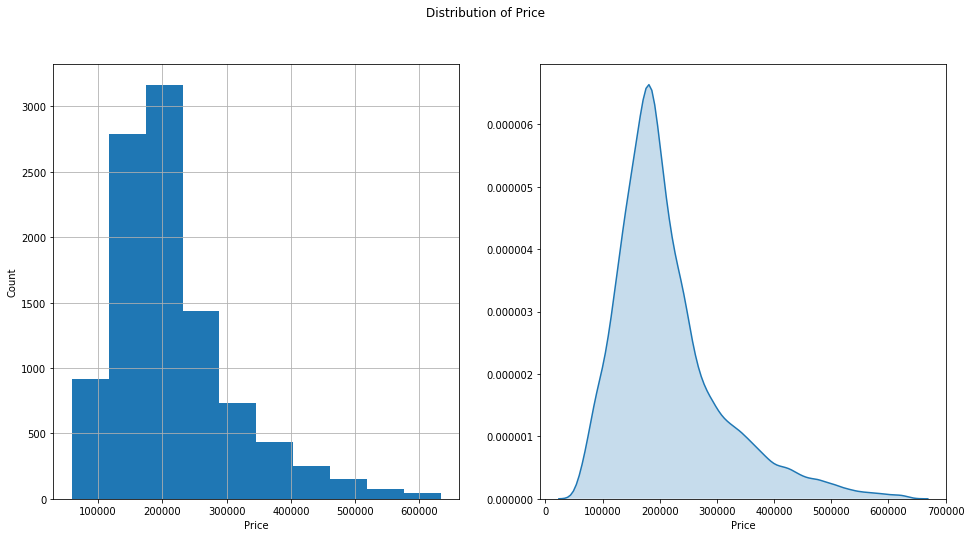

In [164]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
data_train['Price'].hist()
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(data_train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [165]:
target_mean = round(data_train['Price'].mean(), 2)
target_median = data_train['Price'].median()
target_mode = data_train['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.57, 192261.9632697044, 59174.77802758122)

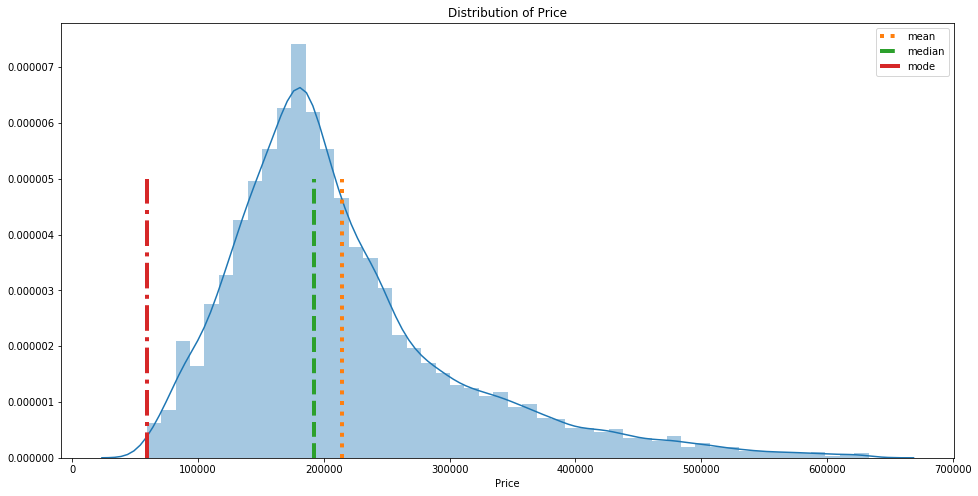

In [166]:
plt.figure(figsize = (16, 8))

sns.distplot(data_train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

In [167]:
num_features = data_train.select_dtypes(include=['float64', 'int64'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BBE0438>,
      dtype=object)

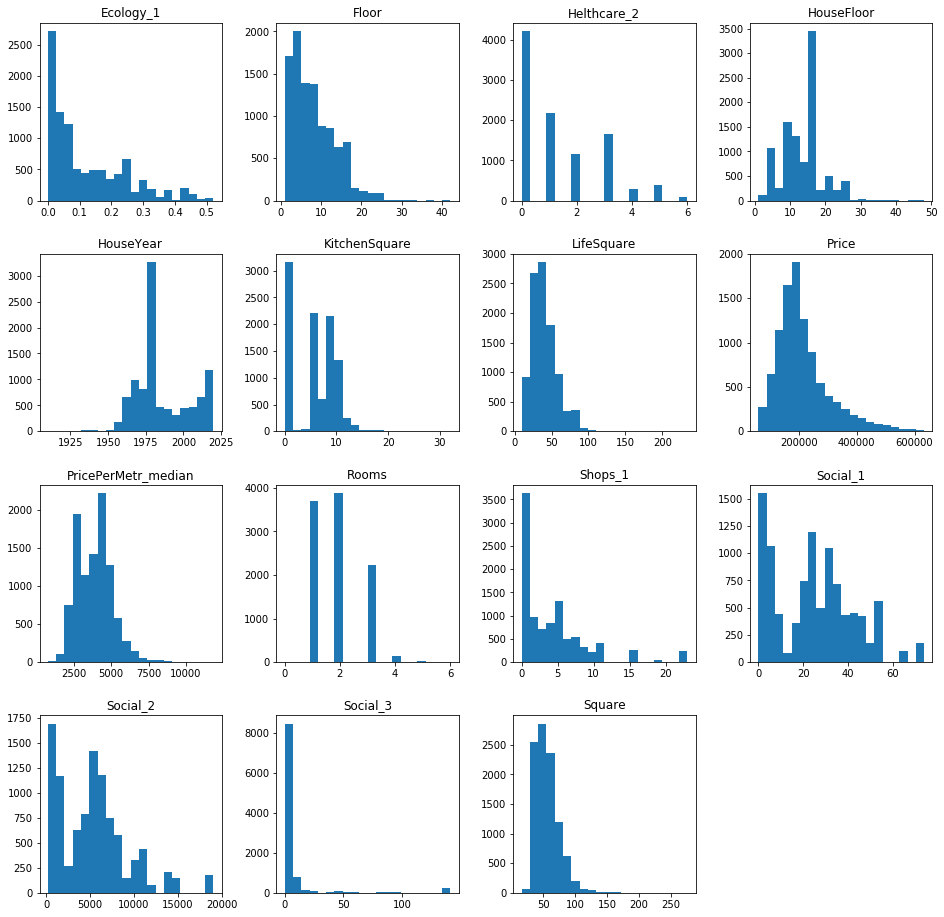

In [168]:
num_features.hist(figsize=(16,16), bins=20, grid=False)

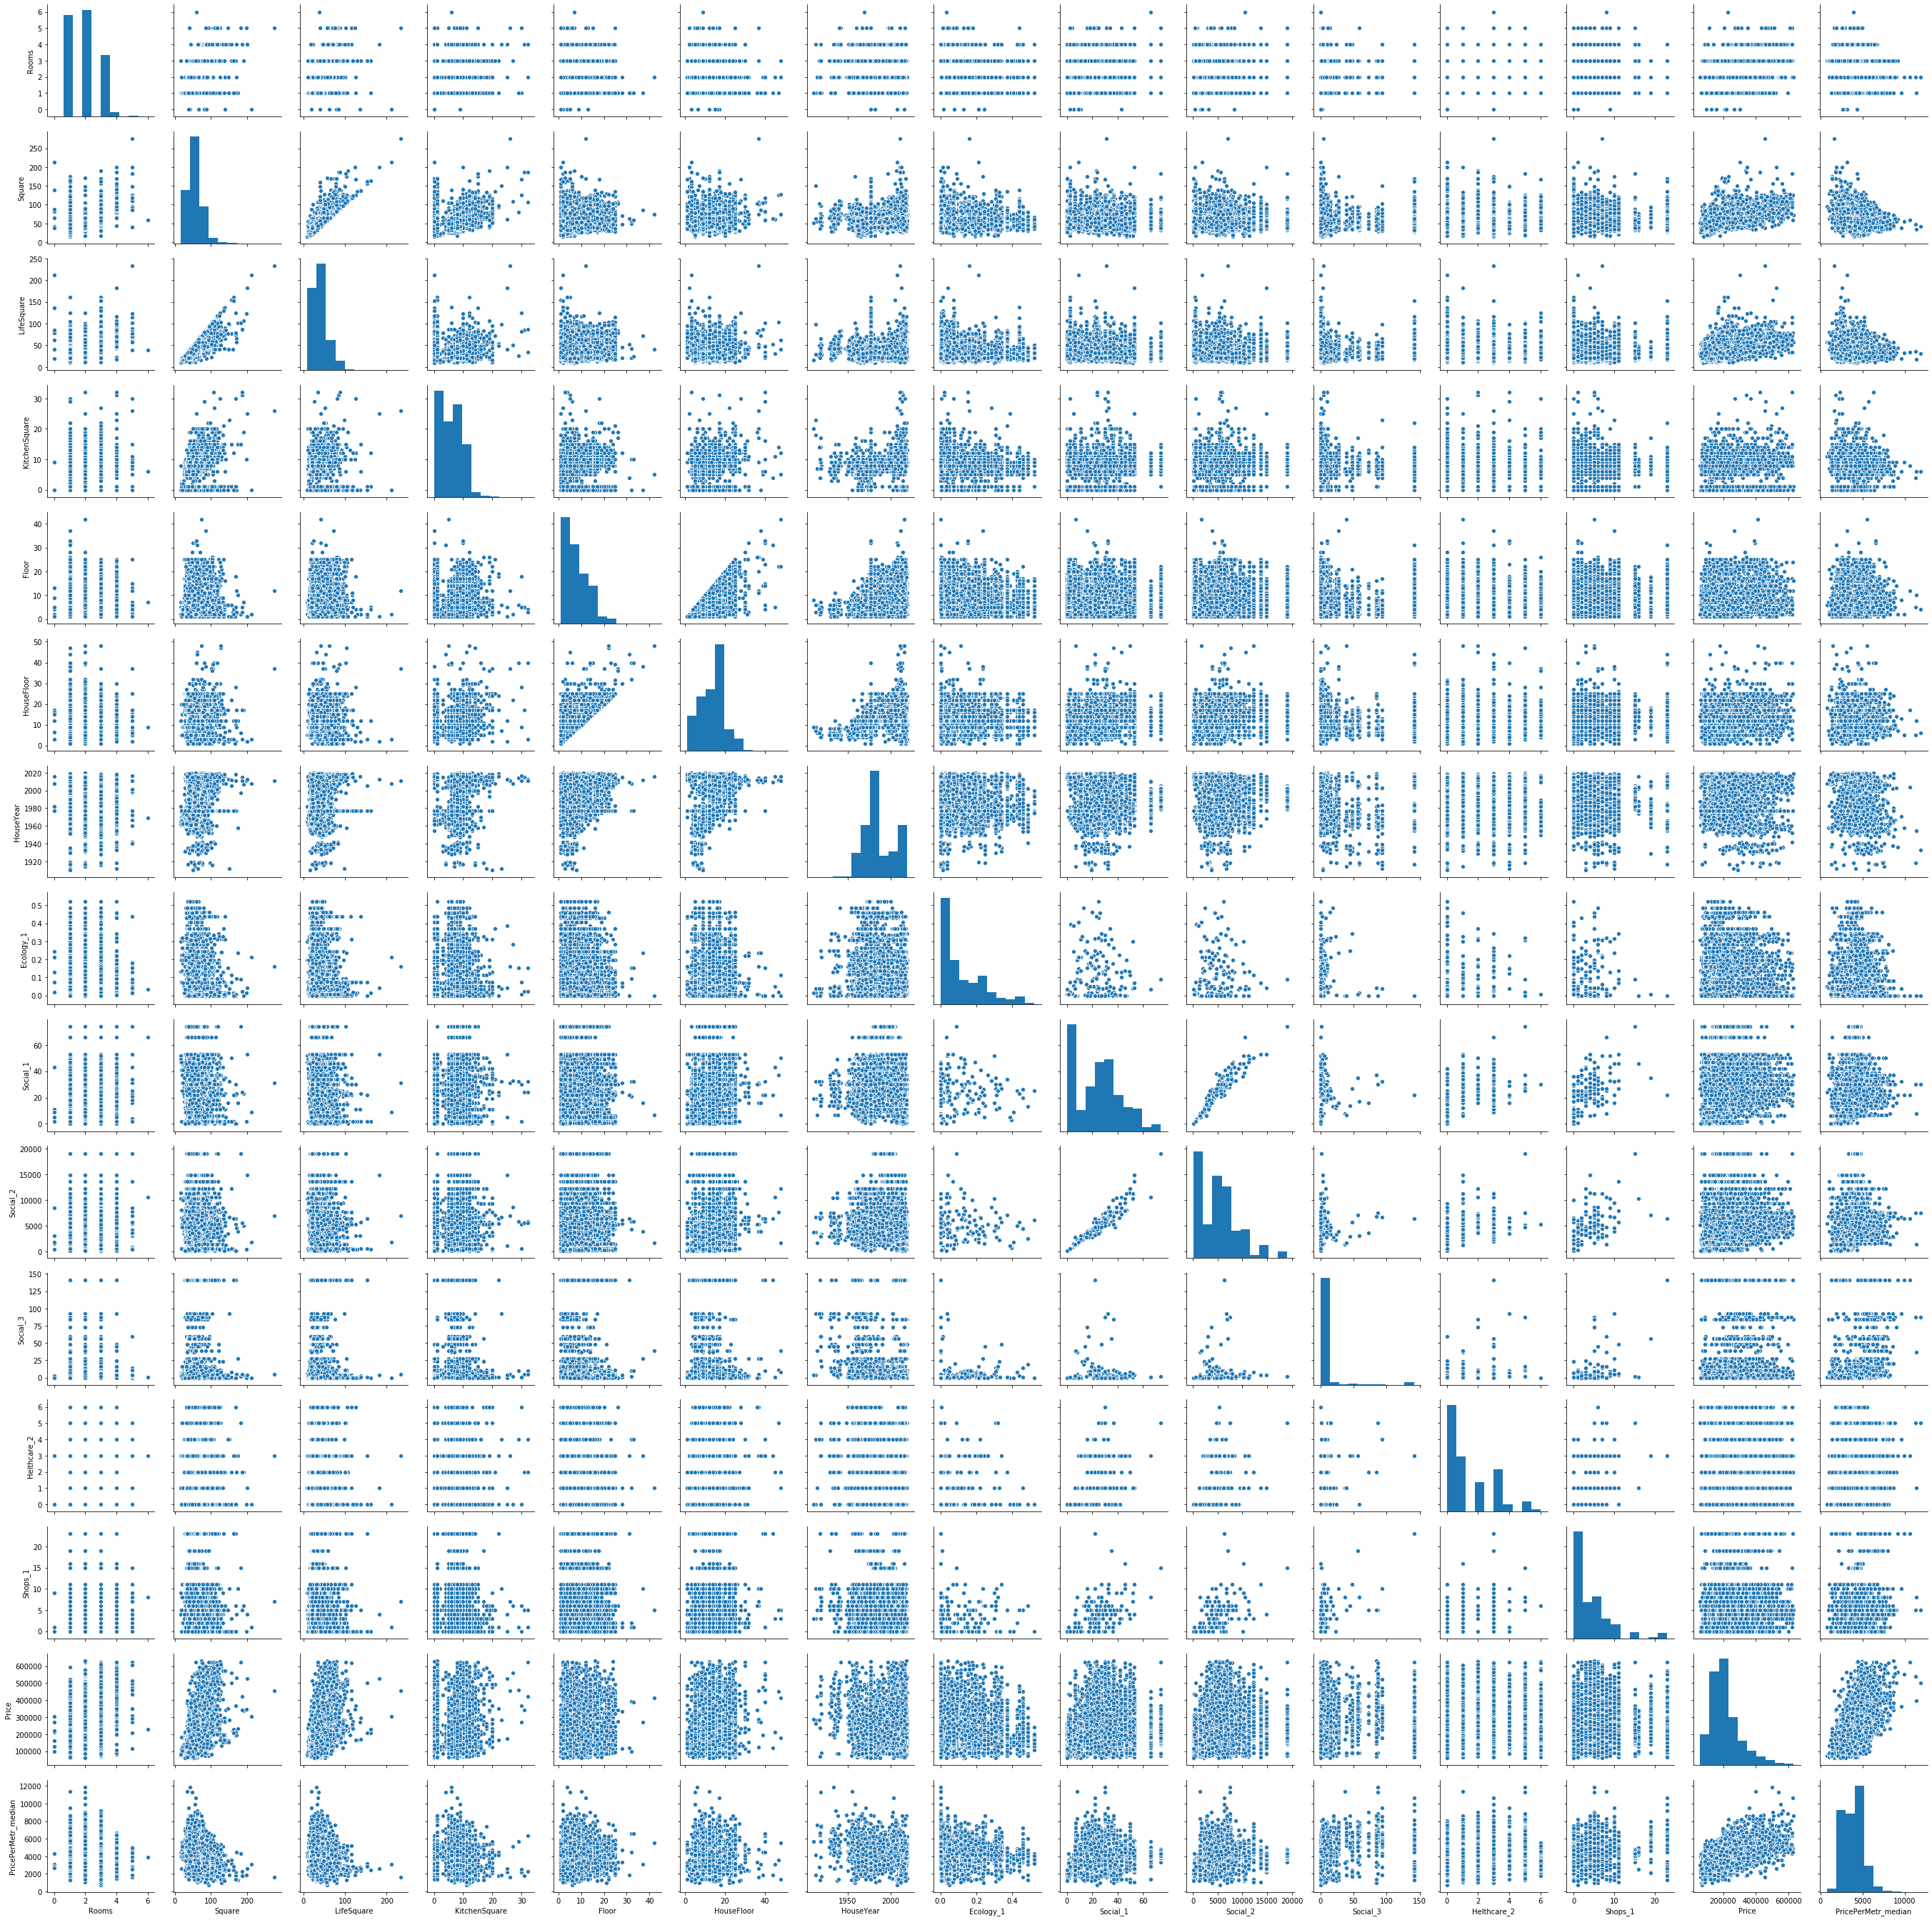

In [169]:
sns.pairplot(num_features)

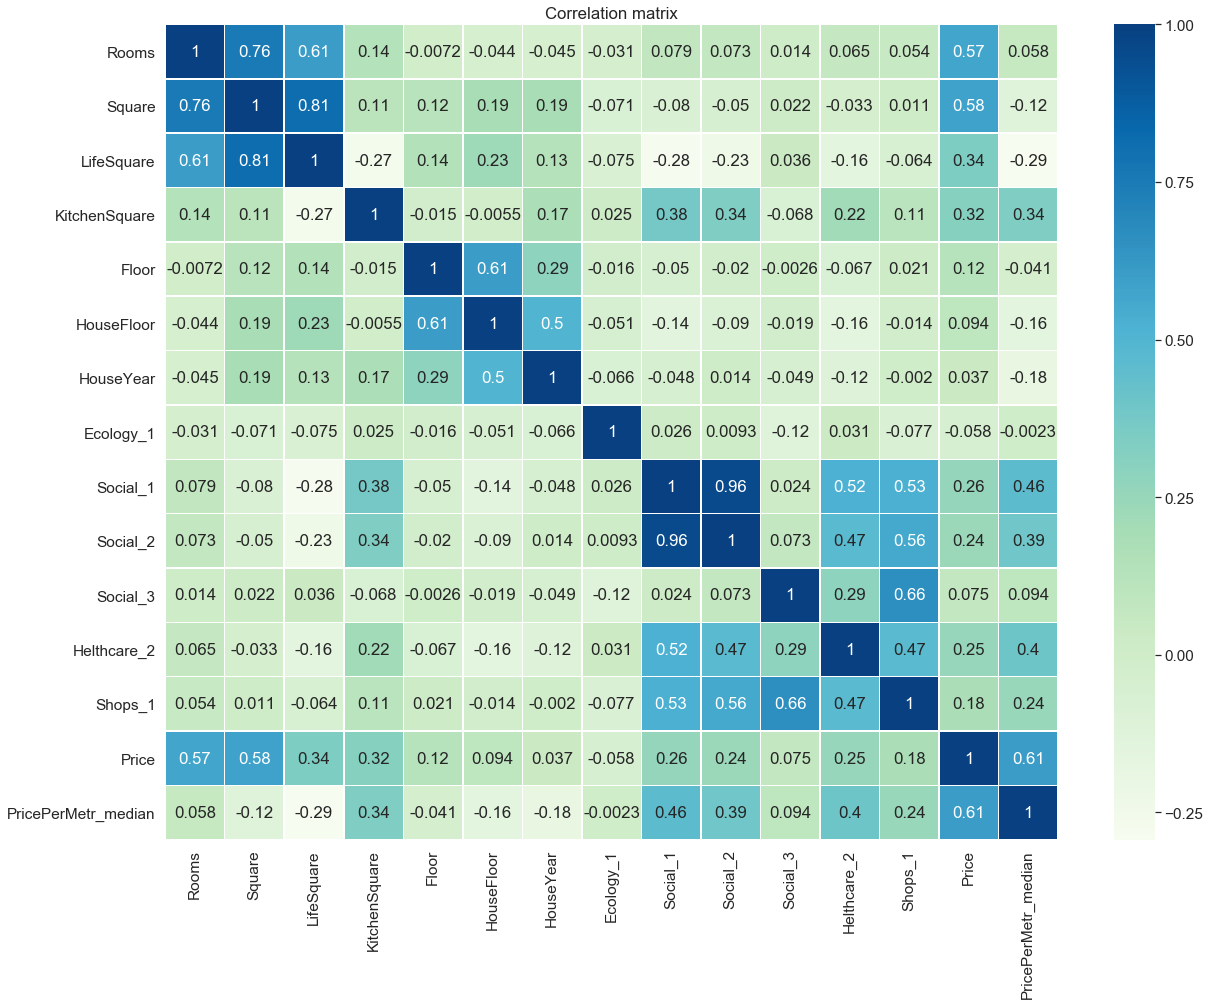

In [170]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# Стандартизация признаков

In [171]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'PricePerMetr_median']
target_name = 'Price'

In [172]:
features_for_stand = data_train[feature_names].columns.tolist()
features_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'PricePerMetr_median']

In [173]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(data_train[features_for_stand])

In [174]:
data_train[features_for_stand] = pd.DataFrame(stand_features, columns=features_for_stand)

In [175]:
stand_features = scaler.transform(data_test[features_for_stand])

In [176]:
data_test[features_for_stand] = pd.DataFrame(stand_features, columns=features_for_stand)

# Разбиение на test и train 

In [177]:
x=data_train.drop(['Price'],axis=1)
y=data_train['Price']

In [178]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, random_state=25)

# Построение тестовой модели

In [179]:
gb = GradientBoostingRegressor(max_features=15, n_estimators=100, max_depth=3)
gb.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=15, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.894


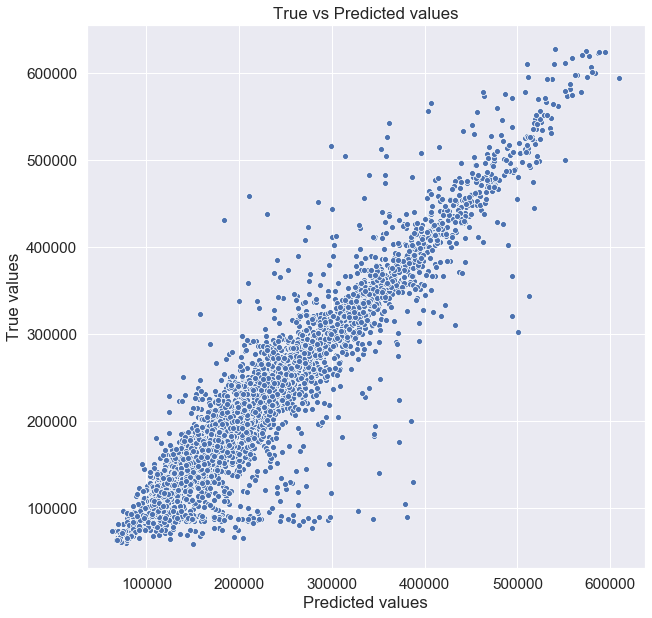

In [180]:
y_train_preds = gb.predict(x_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.877


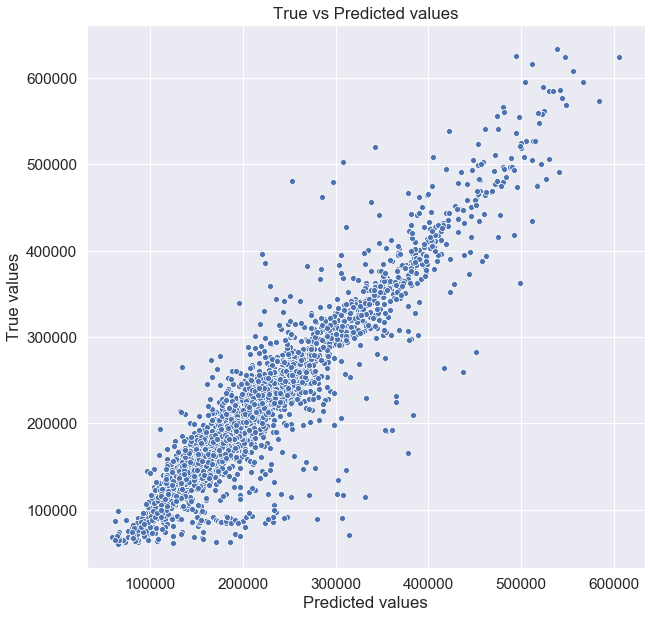

In [181]:
y_test_preds = gb.predict(x_test)
evaluate_preds(y_test, y_test_preds)

# Построение финальной модели

In [182]:
gb = GradientBoostingRegressor(max_features=15, n_estimators=100, max_depth=3)
gb.fit(x, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=15, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [183]:
df_test['Price'] = gb.predict(data_test)

In [184]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,169309.541215
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,209420.069021
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,128953.653798
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,297013.428583
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,133528.668441


In [185]:
df_test.loc[:,['Id','Price']].to_csv('TVetlugina_predictions.csv',index=False)